In [10]:
import os, sys, numpy as np, copy
import scipy.stats as stats
import json
import matplotlib.pyplot as plt

from pdf2image import convert_from_path
from IPython.display import Image, display

import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence

sys.path.append("..")
from mm.models import MealModel, SPTModel
from mm.core import jit
from mm.utils import set_start

In [3]:
HP_FN = os.path.abspath("default_params.json")
with open(HP_FN, "r") as of:
    params = json.load(of)

data1 = np.loadtxt("./datasets/Gintake.dat")
t_data = data1[:, 0]
DGintake_data = data1[:, 1]
Gintake_data = data1[:, 2]
nt = len(DGintake_data)

# load input insulin secretion data
data2 = np.loadtxt("./datasets/glucose_insulin_normal.dat")
G_data = data2[:,1]
I_data = data2[:,2]

In [5]:
# get Gaussian KDE
def get_gaussian_kde(samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    y, bin_edges = np.histogram(samples, bins=25, density=True)
    x = [0.5*(bin_edges[i]+bin_edges[i+1]) for i in range(len(y))]
    return x, y

In [6]:
mealmodelname = "meal_normal"

In [7]:
@jit
def MetaModel1(name="meta1", hpfn = HP_FN, t=2, inputs={}, start={}, evidence={}):
    # define meal model
    meal = MealModel(name=mealmodelname, hpfn=hpfn, inputs=inputs, start=start,
                     evidence=evidence, t=t)

    # prepare inputs to spt model to couple with plasma glucose from meal model
    spt_inputs = copy.copy(inputs)
    spt_inputs.update({"G_in": 0.5 * meal.G})

    # now define spt model with this input
    spt = SPTModel(name="spt", hpfn=hpfn, inputs=spt_inputs, start=start,
                   evidence=evidence, t=t)

    # combine the plasma insulin from both models
    I = pm.Normal("I", mu=0.5*(meal.I + spt.I), sigma=0.1, shape=t)

In [15]:
def run_experiment_1(nsamples=1000):
    # get estimate of k in diabetic conditions

    # specify inputs, evidence, start
    inputs = {"DGintake": DGintake_data}

    evidence = {"%meta1_I" :    I_data}

    start = {"%s_State" % mealmodelname: set_start("State", mealmodelname, hpfn=HP_FN),
             "spt_S": set_start("S", "spt", hpfn=HP_FN),
             "spt_I": set_start("I", "spt", hpfn=HP_FN)}

    # create the metamodel
    print("\nBuilding metamodel-1...")
    m = MetaModel1(name="meta1", inputs=inputs, evidence=evidence,
                   start=start, t=nt)

    # visualize the model
    pm.model_to_graphviz(m).render("metamodel_1")
    os.remove("metamodel_1")
    img = convert_from_path("metamodel_1.pdf")
    img[0].save("metamodel_1.png")
    display(Image("metamodel_1.png"))
    print("here")


Building metamodel-1...


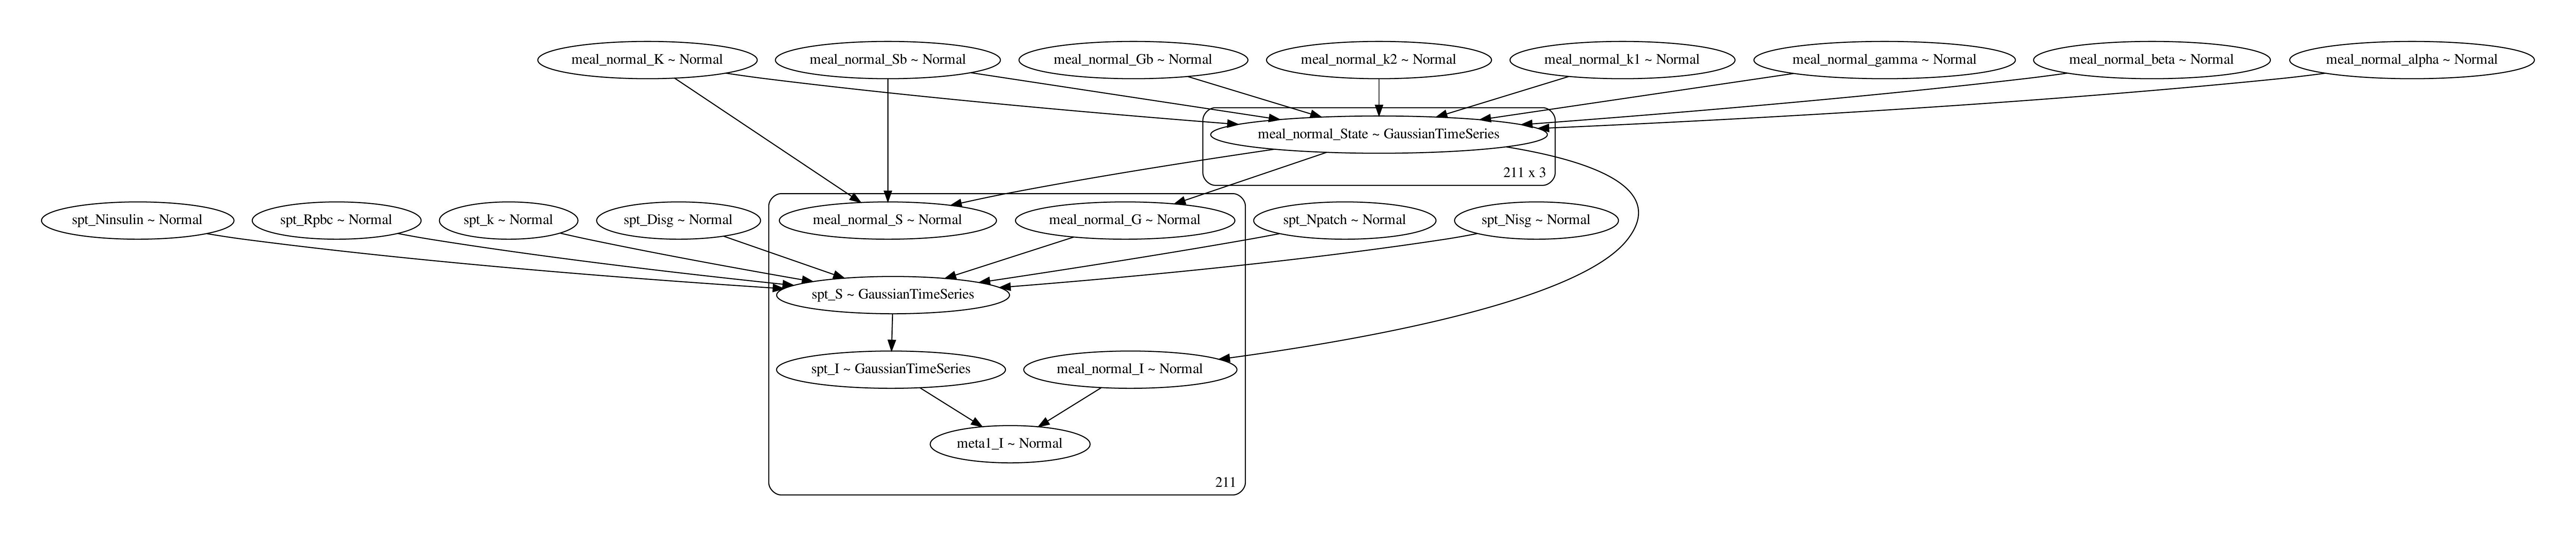

here


In [16]:
run_experiment_1()